# Bayesian Update Function

This notebook reproduces Figure 2 from [Bayesian Flow Networks (Graves et al. 2023)](https://arxiv.org/pdf/2308.07037.pdf). 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

In [2]:
from bfn.bayesian_flow_networks import bayesian_update_function
from bfn.plotting_utils import set_ticks

## Plotting Code

In [3]:
def visualize_figure_2(x, thetas, ys, alphas):
  x_range = np.arange(-1.5, 1.5, 0.01)
  colors = np.concatenate([
      np.array([[0,0,0,1]]),  # black
      plt.cm.Set1(range(3))  # red, blue, green
      ])

  plt.figure(figsize=(13,5))

  # plot x
  plt.axvline(x=x, c=colors[0], linestyle='dashed')

  # plot initial input distribution
  mu_0, rho_0 = thetas[0]
  plt.plot(
      x_range,
      norm.pdf(x_range, mu_0.item(), 1/(rho_0**(0.5)).item()),
      color=colors[0],
      label=f'$p_i(x | \\theta_0)$')


  for i, (theta, y, alpha) in enumerate(zip(thetas[1:], ys, alphas), start=1):
    # plot sender distribution
    plt.plot(
        x_range,
        norm.pdf(x_range, x, 1/alpha**0.5),
        color=colors[i],
        label=f'$p_s(y | x; \\alpha_{i} = {alpha})$',
        linestyle='dotted')

    # plot posterior input distribution
    mu, rho = theta
    plt.plot(
        x_range,
        norm.pdf(x_range, mu.item(), 1/(rho**0.5).item()),
        color=colors[i],
        label=f'$p_i(x | \\theta_{i})$')

    # plot sampled ys
    plt.scatter(
        y,
        norm.pdf(y, x, 1/alpha**0.5),
        color=colors[i],
        marker='x',
        label=f'$y_{i}$'
    )

  # x ticks
  mus = [mu.item() for mu, _ in thetas]
  ticks_labels_colors = [
      (x, f'$x={x}$', colors[0]),
      (mus[0], f'$\\mu_0={mus[0]}$', colors[0]),
      ]
  ticks_labels_colors += [(mus[i], f'$\mu_{i}$', colors[i]) for i in range(1, len(thetas))]
  ticks_labels_colors += [
      (-1, -1, colors[0]),
      (1, 1, colors[0])]
  tick_values, tick_labels, tick_colors = zip(*ticks_labels_colors)
  set_ticks(tick_values, tick_labels, tick_colors)

  plt.legend(loc='upper left')
  plt.title('Figure 2: Bayesian updates for continuous data')

## Reproduce Figure 2

Figure 2 plots the Bayesian updates for initial input distribution parameters $\theta_0 = \{\mu_0=0, \rho_0=1\}$ given univariate data $x=0.7$.

Given a series of sender samples $y_1$, $y_2$, $y_3$ drawn from the sender distribution $p_S(\cdot | x; \alpha) = N(x, \alpha^{-1})$ with accuracies $\alpha=2, \alpha=4, \alpha=6$ respectively, the initial parameters $\theta_0$ are updated to $\theta_1 = \{\mu_1, \rho_1\}$, $\theta_2 = \{\mu_2, \rho_2\}$, $\theta_3 = \{\mu_3, \rho_3\}$ by iterating the following equations:

\begin{align}
\rho_i &= \rho_{i-1} + \alpha \tag{49} \\
\bm{\mu}_i &= \frac{\bm{\mu}_{i-1} \rho_{i-1} + \mathbf{y}\alpha}{\rho_i} \tag{50}
\end{align}
Note how the input mean $(\mu_1, \mu_2, \mu_3)$ stochasticaly approaches the data, while the input precision smoothly increases."

(_The above description is adapted from the caption of Figure 2._)

In [18]:
theta_0 = torch.tensor(0), torch.tensor(1)
x = 0.7

alphas = torch.tensor([2, 4, 6])
thetas = [theta_0]
ys = []

for alpha in alphas:
  y = torch.normal(mean=torch.tensor(x), std=1/alpha**0.5)
  mu_i, rho_i = bayesian_update_function(
    prev_theta=thetas[-1], y=y, alpha=alpha)

  thetas.append((mu_i, rho_i))
  ys.append(y)

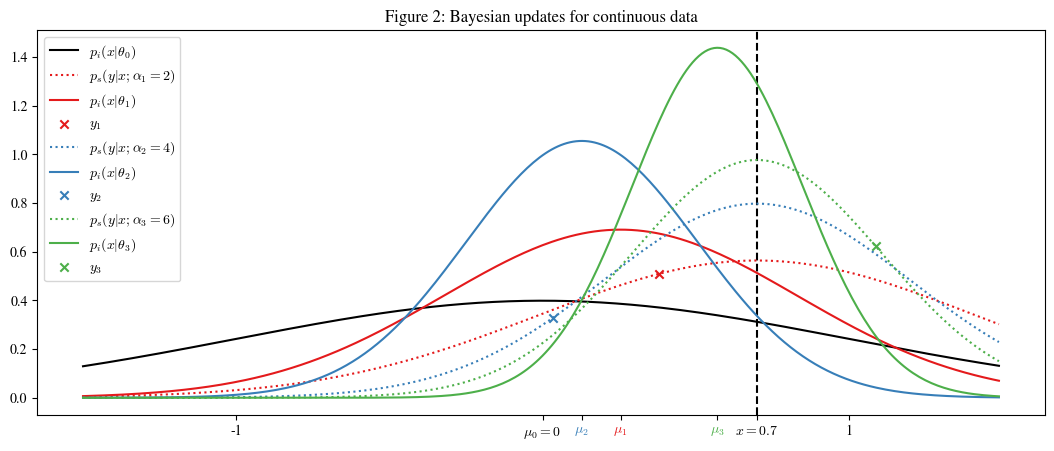

In [19]:
visualize_figure_2(x=x, thetas=thetas, ys=ys, alphas=alphas)